In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2
import re
from collections import Counter
import copy

## Part 1

### Loading dataset

In [2]:
## help taken from https://www.youtube.com/watch?v=Z90KEqJoC3w&ab_channel=Apeer_micro

## extract a list of paths 

file_list_train_pos = glob.glob('Dataset/train/pos/*')
file_list_train_neg = glob.glob('Dataset/train/neg/*.*')
file_list_test_pos = glob.glob('Dataset/test/pos/*.*')
file_list_test_neg = glob.glob('Dataset/test/neg/*.*')

In [3]:
## extract the content(reviews) from each file from the lists of the paths and append to respective list
## train_pos = list of reviews from training data with positive sentiment
## test_pos = list of reviews from test data with positive sentiment
## train_neg = list of reviews from training data with negative sentiment
## test_neg = list of reviews from test data with negative sentiment

train_pos = []
train_neg = []
test_pos = []
test_neg = []

for i in range(len(file_list_train_pos)):
    train_pos.append(np.loadtxt(file_list_train_pos[i], delimiter='\n', dtype=str, encoding='utf-8').tolist())
    train_neg.append(np.loadtxt(file_list_train_neg[i], delimiter='\n', dtype=str, encoding='utf-8').tolist())
    test_pos.append(np.loadtxt(file_list_test_pos[i], delimiter='\n', dtype=str, encoding='utf-8').tolist())
    test_neg.append(np.loadtxt(file_list_test_neg[i], delimiter='\n', dtype=str, encoding='utf-8').tolist())

<ipython-input-3-552e4db0a369>:14: UserWarning: loadtxt: Empty input file: "Dataset/train/neg\2425_4.txt"
  train_neg.append(np.loadtxt(file_list_train_neg[i], delimiter='\n', dtype=str, encoding='utf-8').tolist())
<ipython-input-3-552e4db0a369>:14: UserWarning: loadtxt: Empty input file: "Dataset/train/neg\4179_4.txt"
  train_neg.append(np.loadtxt(file_list_train_neg[i], delimiter='\n', dtype=str, encoding='utf-8').tolist())
<ipython-input-3-552e4db0a369>:13: UserWarning: loadtxt: Empty input file: "Dataset/train/pos\5122_9.txt"
  train_pos.append(np.loadtxt(file_list_train_pos[i], delimiter='\n', dtype=str, encoding='utf-8').tolist())


In [4]:
## Extracts stops words into a list

stop_words = pd.read_csv('Dataset/stop_words.txt')
stop_words_list = stop_words.values.tolist()
temp = []

for list_item in stop_words_list:
    for word in list_item:
        temp.append(word)
        
stop_words_list = temp

### Cleaning Data

In [5]:
## function to clean data
def clean(x):
    
    cleaned_x = []
    for i in range(len(x)):
        if type(x[i]) == list:
            continue
        temp = re.sub(r'[A-Z]', lambda x :  x.group(0).lower(), x[i])   ## convert to lowercase
        temp = re.sub(r'[^a-z\']+', ' ', temp)                          ## removes everything except alphabets and ' 
        temp = re.sub(r'[ ]+', ' ', temp)                               ## removes all extra spaces

        for word in stop_words_list:                                    ## removes all the stop words
            temp = re.sub(r"\b{}\b".format(word)," ",temp)
            
        temp = re.sub(r' i ', ' ', temp)                                ## removes the letter 'i'
        temp = re.sub(r' br br ', ' ', temp)                            ## removes the word br br 
        temp = re.sub(r'[\']+', ' ', temp)                              ## removes the remaining '
        temp = re.sub(r' i ', ' ', temp)
        temp = re.sub(r'[ ]+', ' ', temp)                               ## removes all extra spaces
        cleaned_x.append(temp)
    return cleaned_x

In [6]:
#cleans the data 
cleaned_train_pos = clean(train_pos)
cleaned_train_neg = clean(train_neg)
cleaned_test_pos = clean(test_pos)
cleaned_test_neg = clean(test_neg)

### Creating Bag of Words for Both Classes

In [7]:
## converting the training data into bag of words
## train_pos_bow = bag of words from training data with positive sentiment
## train_neg_bow = bag of words from training data with negative sentiment

train_pos_bow = []

for sentence in cleaned_train_pos:
    for word in sentence.split():
        if word != 'i':
            train_pos_bow.append(word)
            
train_neg_bow = []

for sentence in cleaned_train_neg:
    for word in sentence.split():
        if word != 'i':
            train_neg_bow.append(word)

### Training Naive Bayes Classifier

In [8]:
def TrainNaiveBayes(train_pos_bow, train_neg_bow):
    
    V = copy.deepcopy(train_pos_bow) + copy.deepcopy(train_neg_bow)     ## combines unique words from train_pos_bow and train_neg_bow to make vocabulary
    V = list(set(V))
    V_length = len(V)
    
    total_length = ( len(cleaned_train_pos) + len(cleaned_train_neg) )          ## total length of training data
    
    pos_prior = abs(np.log( len(cleaned_train_pos) / total_length ))        ## probability of class being positive 
    neg_prior = abs(np.log( len(cleaned_train_neg) / total_length ))        ## probability of class being negative
    
    pos_likelihood = {}
    neg_likelihood = {}
    
    pos_word_counts = Counter(train_pos_bow)                            ## gets number of occurence of every word from train_pos_bow
    neg_word_counts = Counter(train_neg_bow)                            ## gets number of occurence of every word from train_neg_bow
    
    for word in V:
        count = pos_word_counts[word]                                   ## gets the number of occurence of a specific word
        pos_likelihood[word] = abs(np.log( (count+1) / (V_length + len(train_pos_bow) ) ))         ## probability of that specific word given positive sentiment
                                                                                                    ## with scaling 
        count = neg_word_counts[word]
        neg_likelihood[word] = abs(np.log( (count+1) / (V_length + len(train_neg_bow) ) ))         ## probability of that specific word given negative sentiment
        
    return (pos_prior, neg_prior), (pos_likelihood, neg_likelihood), V

In [9]:
## 0 index contains positive sentiment probabilities while 1 contain negative sentiment probabilities
## training classifier

priors, likelihoods, V = TrainNaiveBayes(train_pos_bow, train_neg_bow)

### Testing Naive Bayes Classifier

In [10]:
## function to run classifier on test data

def TestNaiveBayes(test, priors, likelihoods, V):
    sum_pos = priors[0]
    sum_neg = priors[1]
    
    for word in test:
        try:
            sum_pos = sum_pos + likelihoods[0][word]        ## sums the probability of all words in test sentence one by one for each sentiment
            sum_neg = sum_neg + likelihoods[1][word]
        except:
            continue
            
    
    if sum_pos < sum_neg:                                   ## if probability of positive greater then classify as postive 
        return 'pos'
    
    elif sum_pos > sum_neg:
        return 'neg'

### Running Naive Bayes on Test Data

In [11]:
pos_results = []        ## contains predicted labels for test data with positive sentiment
neg_results = []        ## contains predicted labels for test data with negative sentiment

for i in range(len(cleaned_test_pos)):
    pos_results.append( TestNaiveBayes(cleaned_test_pos[i].split(), priors, likelihoods, V) )       ## running classifier on test data with positive sentiment
    neg_results.append( TestNaiveBayes(cleaned_test_neg[i].split(), priors, likelihoods, V) )       ## running classifier on test data with negative sentiment

### Evaluation

In [12]:
pos_results_count = Counter(pos_results)
neg_results_count = Counter(neg_results)

true_pos = pos_results_count['pos']
true_neg = neg_results_count['neg']
false_neg = pos_results_count['neg']
false_pos = neg_results_count['pos']

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

confusion_matrix1 = np.zeros([2,2])
confusion_matrix1[0][0] = true_pos
confusion_matrix1[1][1] = true_neg
confusion_matrix1[0][1] = false_pos
confusion_matrix1[1][0] = false_neg

print("Accuracy = ", accuracy*100)
print("Confusion Matrix = ", confusion_matrix1)

Accuracy =  82.548
Confusion Matrix =  [[ 9614.  1477.]
 [ 2886. 11023.]]


### Plotting Confusion Matrix

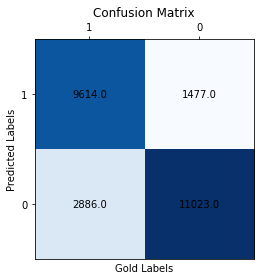

In [13]:
fig, (ax) = plt.subplots(1, 1)
im = ax.imshow(confusion_matrix1, cmap='Blues')

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))

ax.set_xticklabels([1, 0])
ax.set_yticklabels([1, 0])

ax.set_xlabel('Gold Labels')
ax.set_ylabel('Predicted Labels')

for i in range(2):
        for j in range(2):
            text = ax.text(j, i, confusion_matrix1[i, j], ha="center", va="center", color="black")

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    
ax.set_title("Confusion Matrix")      
plt.tight_layout()
plt.show()

## Part 2

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Vectorizing the Data

In [15]:
vectorizer = CountVectorizer(input='filename', stop_words=stop_words_list)          ## vectorizing training data and making vocabulary
train_X = vectorizer.fit_transform((file_list_train_pos+file_list_train_neg))

train_x_pos_labels = np.ones((1,len(file_list_train_pos)))
train_x_neg_labels = np.zeros((1,len(file_list_train_neg)))
train_Y = np.concatenate((train_x_pos_labels, train_x_neg_labels), axis=1)          ## preparing training labels

test_X = vectorizer.transform((file_list_test_pos+file_list_test_neg))              ## vectorizing test data from the vocabulary from test data

test_x_pos_labels = np.ones((1,len(file_list_test_pos)))
test_x_neg_labels = np.zeros((1,len(file_list_test_neg)))
test_Y = np.concatenate((test_x_pos_labels, test_x_neg_labels), axis=1)             ## preparing test labels 

### Training Naive Bayes Classifier 

In [16]:
classifier = MultinomialNB()
classifier.fit(train_X, train_Y.flatten())
predicted = classifier.predict(test_X)

### Evaluation

In [17]:
accuracy2 = accuracy_score(test_Y.flatten(), predicted)
confusion_matrix2 = confusion_matrix(test_Y.flatten(), predicted)
print("Accuracy = ", accuracy2*100)
print("Confusion Matrix = ", confusion_matrix2 )

Accuracy =  82.392
Confusion Matrix =  [[11017  1483]
 [ 2919  9581]]


### Plotting Confusion Matrix

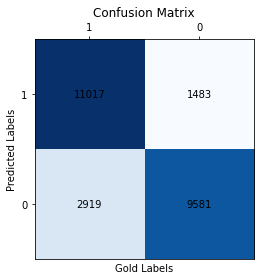

In [18]:
fig, (ax) = plt.subplots(1, 1)
im = ax.imshow(confusion_matrix2, cmap='Blues')

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))

ax.set_xticklabels([1, 0])
ax.set_yticklabels([1, 0])

ax.set_xlabel('Gold Labels')
ax.set_ylabel('Predicted Labels')

for i in range(2):
        for j in range(2):
            text = ax.text(j, i, confusion_matrix2[i, j], ha="center", va="center", color="black")

ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    
ax.set_title("Confusion Matrix")      
plt.tight_layout()
plt.show()